In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, os.path.expanduser("~/Developer/interpretDL/Pipeline"))

In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
import numpy as np
import pandas as pd
import umap

from datetime import datetime
from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix, plot_history, plot_3d_lrp
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE) 

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [4]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.close("History")
    fig, axs = plt.subplots(1, 2, figsize=(20,10),num="History")

    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [5]:
np.round(211)

211

In [6]:
fname = "data/cleaned_SA.csv"
raw_data = pd.read_csv(fname, index_col=0)
raw_data.head()

,ASD_DX_group,Risk,ROI01,ROI02,ROI03,ROI04,ROI05,ROI06,ROI07,ROI08,...,ROI324,ROI325,ROI326,ROI327,ROI328,ROI329,ROI330,ROI331,ROI332,ROI333
CandID,,,,,,,,,,,,,,,,,,,,,
103430,TYPICAL,HR,529.158386,298.568665,190.627472,134.555801,363.573608,646.810547,33.957870,172.629700,...,46.523426,88.635681,15.326110,268.573364,143.174347,1.515198,239.148468,20.107052,34.309757,10.180353
107524,ASD,HR,518.345703,311.013794,118.777634,198.685638,477.074524,405.450134,55.401951,126.927612,...,30.664413,76.203514,25.545485,188.544678,107.464104,1.381342,188.476715,17.961386,23.440365,14.530558
108372,TYPICAL,LR,443.658081,156.824844,157.223099,147.381149,492.784088,305.069519,61.638298,136.602600,...,35.009350,99.737000,23.199062,282.846497,29.161158,0.722310,200.596985,28.989164,32.400013,10.532928
113320,TYPICAL,LR,529.817078,301.160583,129.092483,151.090851,395.564331,597.880981,32.048248,163.701218,...,40.359753,111.341911,15.794782,214.678467,75.857338,1.767594,179.606552,16.667351,44.315159,12.016207
114640,TYPICAL,LR,689.399170,303.337524,154.169434,98.182709,592.248962,364.648315,10.539658,142.580795,...,49.686398,134.082794,18.534616,217.291306,36.213020,1.580427,181.796356,22.934441,63.739361,10.897783


In [7]:
raw_data.shape

(325, 335)

In [8]:
label_cols = ["ASD_DX_group", "Risk"]
noisy_cols = []

features = raw_data.drop(columns=noisy_cols+label_cols)
labels = raw_data[label_cols].copy()

In [9]:
labels["ASD_DX_group"][labels["Risk"]=="HR"].value_counts()

TYPICAL            149
ASD                 39
ATYPICAL_ADOS       17
ATYPICAL_MULLEN      9
Name: ASD_DX_group, dtype: int64

In [10]:
LR = labels["Risk"]=="LR"
typical = labels["ASD_DX_group"]=="TYPICAL"
ASD = labels["ASD_DX_group"]=="ASD"
HR = labels["Risk"]=="HR"

In [11]:
LR_typical = labels[LR & typical]
HR_ASD = labels[HR & ASD]

In [12]:
analysis_labels = pd.concat((LR_typical, HR_ASD))
analysis_labels["Risk"].value_counts()

LR    99
HR    39
Name: Risk, dtype: int64

In [13]:
enc = OrdinalEncoder()
enc.fit(analysis_labels)
enc_labels = enc.transform(analysis_labels)
enc.categories_

[array(['ASD', 'TYPICAL'], dtype=object), array(['HR', 'LR'], dtype=object)]

In [14]:
risk_labels = pd.Series(enc_labels[:,1], dtype=int, index=analysis_labels.index)
data = features.loc[analysis_labels.index].copy()

# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.2)

print(train_data.shape)
train_labels.value_counts()

(110, 333)


1    79
0    31
dtype: int64

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

ZScaler = StandardScaler().fit(train_data)
X_train = ZScaler.transform(train_data)
X_valid = ZScaler.transform(test_data)

y_train = train_labels.values.reshape(-1,1)
y_valid = test_labels.values.reshape(-1,1)

class_weight = compute_class_weight("balanced", np.unique(train_labels), train_labels)
class_weight

array([1.77419355, 0.69620253])

In [16]:
def build_dnn(num_features, num_labels, activation="elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    from keras.constraints import max_norm
    keras.backend.clear_session()
    
    tf.random.set_random_seed(RANDOM_STATE)
    reg_scale = 0.01 # For L1 Reg
    my_reg = regularizers.l2(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = keras.initializers.he_normal(seed=RANDOM_STATE)

    dnn.add(Dense(units = 64, activation=activation, input_dim = num_features,
                  kernel_initializer=he_init,  kernel_regularizer=my_reg))
    dnn.add(keras.layers.Dropout(0.2)),
    dnn.add(Dense(units = 64, activation=activation,
                  kernel_initializer=he_init,  kernel_regularizer=my_reg))
    dnn.add(keras.layers.Dropout(0.2))
    
    dnn.add(Dense(units=num_labels, activation="sigmoid",
                  kernel_initializer=he_init,  kernel_regularizer=my_reg)) # 5 labels -> logits for now
    
#     SGD=keras.optimizers.SGD(lr=0.001)
    NSGD = keras.optimizers.SGD(lr=0.001,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='binary_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy']) #Internally it seems to be same as binary accuracy
    
    return dnn

In [83]:
time = datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir='./logs/{}_baseline_10'.format(time),
                          update_freq="epoch", write_graph=False)

In [84]:
%%time
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="elu")
history = dnn.fit(X_train, y_train, validation_data=(X_valid,y_valid),class_weight=class_weight,
                  epochs=5000, batch_size=10, verbose=0, callbacks=[tensorboard])

CPU times: user 1min 45s, sys: 27.2 s, total: 2min 12s
Wall time: 56.5 s


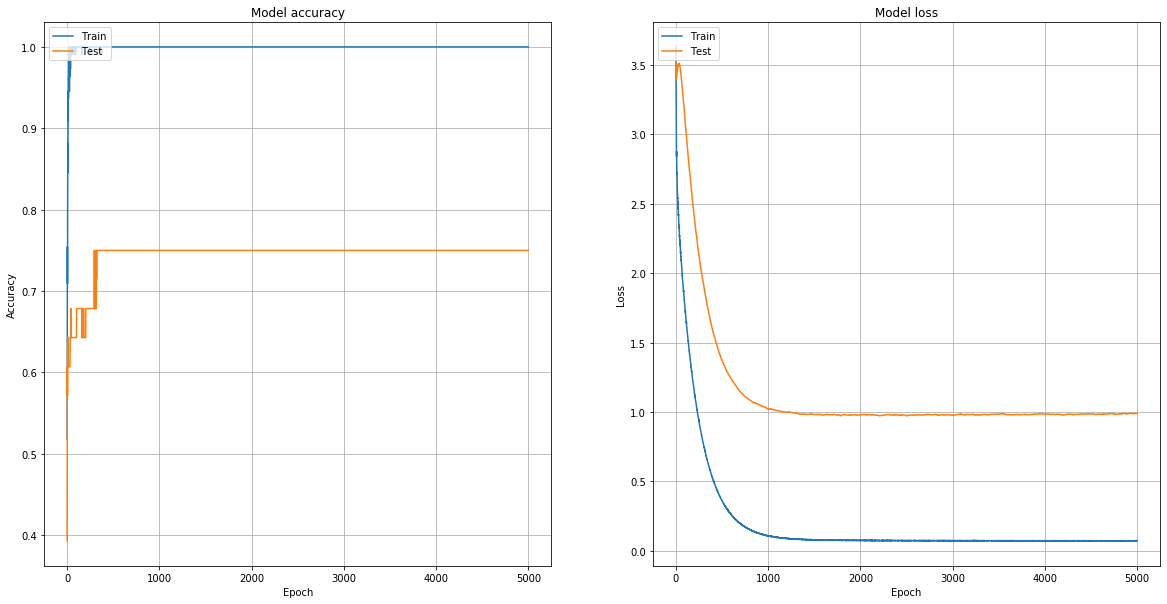

28/28 [==============================] - 0s 27us/step
Loss:0.989, Acc:0.7500


In [85]:
plot_history(history)
print("Loss:{:0.3f}, Acc:{:.4f}".format(*dnn.evaluate(X_valid,y_valid)))

Confusion matrix, without normalization
[[0.25 0.75]
 [0.05 0.95]]
Overall Accuracy: 0.7500


(<matplotlib.axes._subplots.AxesSubplot at 0x1a3f11d668>, array([[ 2,  6],
        [ 1, 19]]))

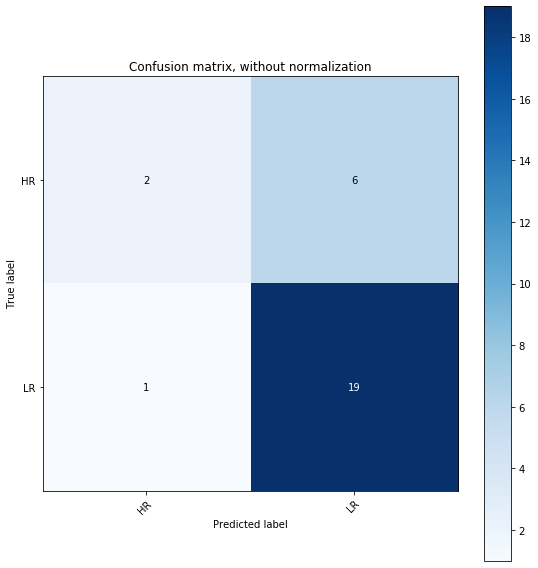

In [86]:
y_pred = np.round(np.ravel(dnn.predict(X_valid)))
plot_confusion_matrix(np.ravel(y_valid), y_pred, enc.categories_[1])

In [87]:
from sklearn.metrics import precision_score, make_scorer
prec_scorer = make_scorer(precision_score, pos_label=0)

precision_score(y_true=np.ravel(y_valid), y_pred=y_pred, pos_label=0)

0.6666666666666666

### Cross Validating

In [17]:
# Separating a hold out set that will be used for validation of the pipeline
# train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.01)
train_data, train_labels, test_data, test_labels = data, risk_labels, [], []

In [18]:
risk_labels.value_counts()

1    99
0    39
dtype: int64

In [19]:
train_data.shape

(138, 333)

In [20]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=5,
                    min_dist=0)

In [21]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="relu")
pipeline = ClusterPipeline(dnn, [train_data, train_labels], [test_data, test_labels],
                           target_class=0, reducer=reducer, softmax=False, analyzer_type="lrp.epsilon")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Using TensorFlow backend.


Running Pool...
Initialized Pool...
Runtime: 155.461s
Correct: 100
Test Size: 138
Confusion matrix, without normalization
[[0.46153846 0.53846154]
 [0.17171717 0.82828283]]
Overall Accuracy: 0.7246
Loading LRP Analyzers...
Done!


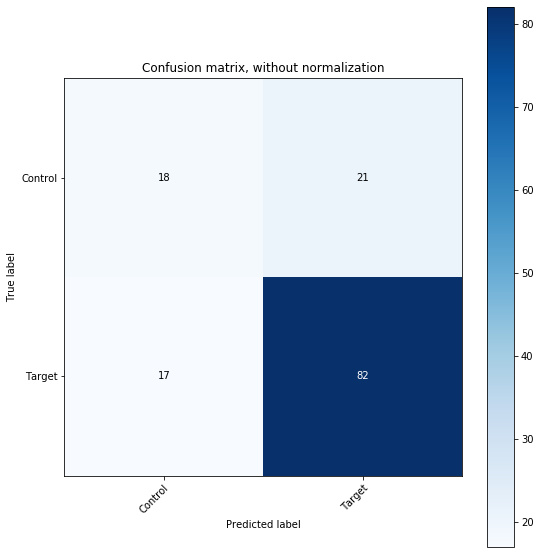

In [22]:
cm = pipeline.train_model(batch_size=int(10), epochs=2000, cross_validation=True,
                          parallel=True, verbose=0, smote=True)

In [23]:
correct_ASD = int(cm[0][0])
print("Sensitivity: {:.4f}".format(correct_ASD/ np.sum(cm,axis=1)[0]))
print("PPV: {:.4f}".format(correct_ASD/ np.sum(cm,axis=0)[0]))

Sensitivity: 0.4615
PPV: 0.5143


In [24]:
from sklearn.preprocessing import MinMaxScaler
reducer = umap.UMAP(random_state=42,
                    n_components = correct_ASD-2,
                    n_neighbors=3,
                    min_dist=0)

pipeline.reducer_pipeline = Pipeline([
            ("umap", reducer),
            ("scaler",  MinMaxScaler())
        ])

_, correct_pred_idxs = pipeline.train_clusterer(plot=False, class_label = 0)
print("Clusters Found:", max(pipeline.clusterer.labels_)+1)

LRP Shape:  (18, 333)
Cluster Search Space: range(3, 6)
Minimum Size:
Clusters                  (4, 4)
Noise                     (5, 3)
Halkidi                   (3, 3)
Halkidi-Filtered Noise    (3, 3)
dtype: object
Clusters Found: 3


In [25]:
reindexed_labels = train_labels.iloc[pipeline.testing_idxs]
correct_idxs = pipeline.correct_preds_bool_arr
reindexed_labels.shape

(138,)

In [26]:
_correct=analysis_labels.loc[reindexed_labels[correct_idxs].index]
correct_HR = _correct[_correct["Risk"]=="HR"]
# enc.transform(correct_HR)[:,0]

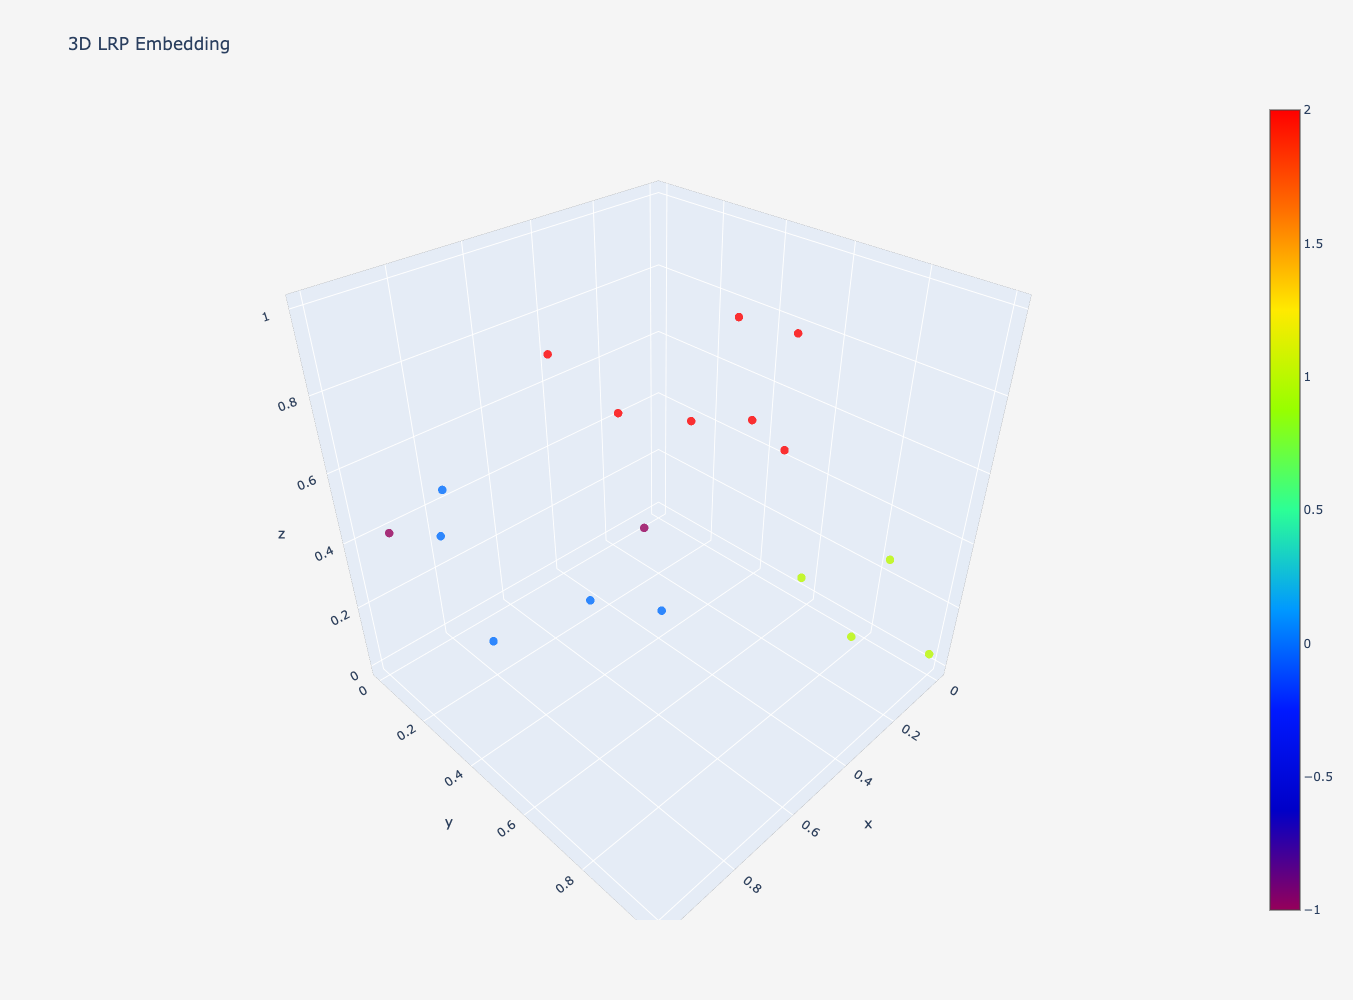

In [27]:
plot_3d_lrp(pipeline.training_lrp, colors=pipeline.clusterer.labels_, labels=correct_HR["ASD_DX_group"])

In [ ]:
# 10 / 500 & 20 / 1000
Sensitivity: 0.3846
PPV: 0.4412

In [ ]:
Sensitivity: 0.4615
PPV: 0.5000

# Check sample IDs

In [28]:
reindexed_labels = train_labels.iloc[pipeline.testing_idxs]
correct_idxs = pipeline.correct_preds_bool_arr
_correct=analysis_labels.loc[reindexed_labels[correct_idxs].index]
correct_HR = _correct[_correct["Risk"]=="HR"]
correct_HR

,ASD_DX_group,Risk
CandID,,
172993,ASD,HR
402809,ASD,HR
930203,ASD,HR
983222,ASD,HR
809318,ASD,HR
812857,ASD,HR
490878,ASD,HR
751794,ASD,HR
336576,ASD,HR


# Comparing with predictions from other features
> ## Note that CSF is gtrained using a larger sample size so some predictions are not in SA/CT training set

In [121]:
from matplotlib_venn import venn2, venn3

sa_preds = set(correct_HR.index)
csf_preds = set(pd.read_csv("csf_only_correct.csv", index_col=0).index)
csf_red_preds = csf_preds.intersection(train_labels.index)
ct_preds = set(pd.read_csv("ct_only_correct.csv", index_col=0).index)

print("SA :", len(sa_preds))
print("CSF:", len(csf_preds))
print("CT :", len(ct_preds))

SA : 18
CSF: 25
CT : 11


## Looking at samples from SA, CT and CSF

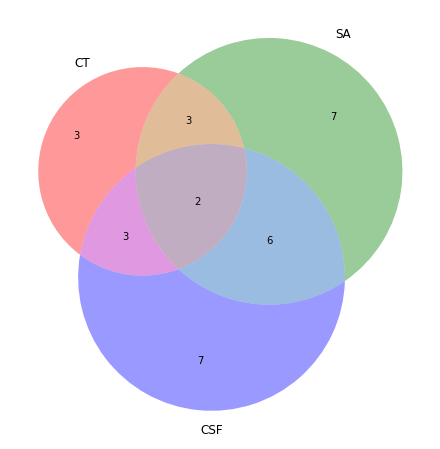

Total: 31


In [132]:
from matplotlib_venn import venn3
plt.figure(figsize=(8,8))
venn3([ct_preds, sa_preds, csf_red_preds], ('CT', 'SA', 'CSF'))
plt.show()
print("Total:", len(ct_preds | sa_preds | csf_red_preds))

## Comparing CSF and SA

In [122]:
print("Samples shared:", len(csf_red_preds))
# csf_red_preds

Samples shared: 18


In [123]:
intersect = csf_red_preds.intersection(sa_preds)
print("Samples predicted by both:",len(intersect))
# intersect

Samples predicted by both: 8


In [124]:
csf_only = set(csf_red_preds) - set(intersect)
print("Predicted using only CSF:", len(csf_only))
# csf_only

Predicted using only CSF: 10


In [125]:
sa_only = set(sa_preds) - set(intersect)
print("Predicted using only SA:", len(sa_only))
# sa_only

Predicted using only SA: 10


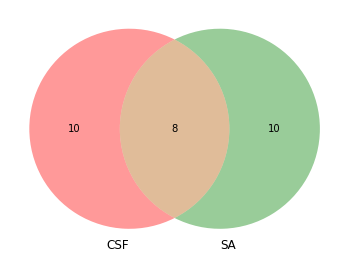

Total: 28


In [126]:
plt.figure(figsize=(6,6))
venn2([csf_red_preds,sa_preds], ['CSF', 'SA'])
plt.show()
print("Total:", len(csf_red_preds.union(sa_preds)))

## Comparing at CT and SA

In [127]:
ct_intersect = ct_red_preds.intersection(sa_preds)
print("Samples predicted by CT and SA:",len(ct_intersect))
# ct_intersect

Samples predicted by CT and SA: 5


In [128]:
ct_only = set(ct_red_preds) - set(ct_intersect)
print("Predicted using only CT:", len(ct_only))
# ct_only

Predicted using only CT: 6


In [129]:
sa_only_ = set(sa_preds) - set(ct_intersect)
print("Predicted using only SA:", len(sa_only_))
# sa_only_

Predicted using only SA: 13


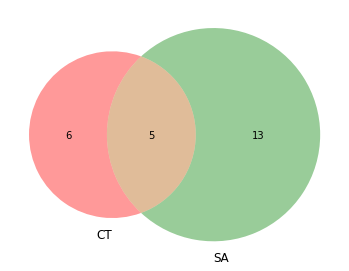

Total: 24


In [130]:
plt.figure(figsize=(6,6))
venn2([ct_preds,sa_preds], ['CT', 'SA'])
plt.show()
print("Total:", len(ct_preds.union(sa_preds)))